
Trong notebook này, chúng ta sẽ thử quy trình lập trình RNN với Keras để phân loại các câu văn bản.

I.   **Trước tiên**, chúng ta sẽ nhập các thư viện hữu ích.

II.   **Sau đó**, chúng ta sẽ load dữ liệu và tạo ma trận word embedding bằng Glove.

III.  **Chúng ta sẽ thử một mô hình RNN đơn giản** rồi đánh giá chất lượng của nó.

IV. Cuối cùng, chúng ta sẽ sử dụng các kỹ thuật để gia tăng độ chính xác của mô hình.

**Task 1:** Thiết lập Fre GPU trong notebook này.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-73f63a4b-a29d-e2cb-34b5-b53ef29d4dcf)


## Gắn Google Drive cục bộ
**Task 2:** Gắn Google vào Google Colab Driver.


In [2]:
## VIẾT CODE cho task 2 ở đây:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Nhập tất cả các thư viện hữu ích.

In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.0 MB/s eta 0:00:00


In [4]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plot
import seaborn as sn

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Task 3**: Copy tập dữ liệu từ Google Drive vào Colab

In [5]:
## VIẾT CODE cho task 3 ở đây:
data_dir = '/content/drive/MyDrive/FUNIX/MON4/ASM2/'

# II. Load dữ liệu.

## Về tập dữ liệu.
Câu hỏi không hợp lệ là những câu hỏi nhằm đưa ra một tuyên bố thay vì tìm kiếm những câu trả lời hữu ích. Một số đặc điểm cho thấy câu hỏi không hợp lệ gồm:

* Có giọng điệu không trung lập.
* Có tính chê bai hoặc kích động.
* Không có căn cứ thực tế.
* Sử dụng nội dung khiêu dâm (loạn luân, thú tính, ấu dâm) để gây sốc, không phải để tìm kiếm câu trả lời xác thực.

Dữ liệu bao gồm câu hỏi đã đề ra và liệu nó có được xác định là không hợp lệ hay không (target = 1).

**Task 4**: Load tập dữ liệu.
* Load dữ liệu từ file CSV.
* Xóa tất cả các hàng có giá trị NA.
* Chia dữ liệu thành 3 tập: Tập huấn luyện, tập kiểm định và tập kiểm tra (0.9/0.05/0.05, random_seed = 9) với cùng một tỷ lệ số dữ liệu giữa mỗi lớp.
* In ra mô tả của tập dữ liệu này.




In [6]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set và test_set(0.9/0.05/0.05) mà không có các giá trị NA.
    '''
    ## VIẾT CODE cho task 4 ở đây:
    file_name = data_dir + data_link
    data = pd.read_csv(file_name)
    data.rename(columns={'target':'label'}, inplace=True)
    data = data.dropna()
    train, validation, test = np.split(data.sample(frac=1),[int(0.9*len(data)), int(0.95*len(data))])
    return train, validation, test

np.random.seed(9)
train_set, validation_set, test_set = load_data('train.csv')

print(train_set['label'].describe())
print(validation_set['label'].describe())
print(test_set['label'].describe())

count    1.175509e+06
mean     6.190340e-02
std      2.409801e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: label, dtype: float64
count    65306.000000
mean         0.062261
std          0.241630
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64
count    65307.000000
mean         0.060882
std          0.239115
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


# Mã hóa dữ liệu văn bản.
Hãy khai báo một số tham số cơ bản trước:

In [7]:
embed_size = 50 # mỗi vectơ từ lớn bao nhiêu
max_features = 20000 # cần sử dụng bao nhiêu từ duy nhất (tức là số hàng trong vectơ embedding)
max_len = 50 # sử dụng số từ tối đa trong câu hỏi

**Task 5:** Mã hóa tập dữ liệu bằng Tokenizer và vectơ biểu diễn one-hot.
* Mã hóa văn bản (cột question_text) bằng cách chuyển từng question text thành danh sách chỉ mục từ bằng [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) với **max_features** và tất cả các câu văn bản từ tập huấn luyện và tập kiểm định.
* Chuyển từng danh sách chỉ mục từ thành độ dài như nhau - **max_len** (có cắt tỉa hoặc đệm nếu cần) bằng cách sử dụng [pad_sequences](https://keras.io/preprocessing/sequence/).
* Mã hóa nhãn (cột nhãn) bằng cách sử dụng hàm [to_categorical](https://keras.io/utils/) trong Keras.

In [8]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    ## VIẾT CODE cho task 5 ở đây:
    # Gộp tất cả các câu văn bản từ tập huấn luyện và tập kiểm định
    tr_va_sentences = np.concatenate((np.array(train_set["question_text"]), np.array(validation_set["question_text"])))

    # Mã hóa 'question text' thành danh sách chỉ mục từ
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n''')
    tokenizer.fit_on_texts(tr_va_sentences)

    train_sentences = train_set['question_text'].values
    validation_sentences = validation_set['question_text'].values
    test_sentences = test_set['question_text'].values

    # Chuyển từng danh sách chỉ mục từ thành độ dài như nhau
    X_tr = pad_sequences(tokenizer.texts_to_sequences(train_sentences),
                         maxlen=max_len,
                         padding='pre',
                         truncating='pre',
                         value=0.0)
    X_va = pad_sequences(tokenizer.texts_to_sequences(validation_sentences),
                         maxlen=max_len,
                         padding='pre',
                         truncating='pre',
                         value=0.0)
    X_te = pad_sequences(tokenizer.texts_to_sequences(test_sentences),
                         maxlen=max_len,
                         padding='pre',
                         truncating='pre',
                         value=0.0)

    # Mã hóa nhãn
    y_tr = to_categorical(train_set['label'], num_classes=2)
    y_va = to_categorical(validation_set['label'], num_classes=2)
    y_te = to_categorical(test_set['label'], num_classes=2)
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

**Task 6**: Tạo ma trận word embedding.
* Đầu tiên, hãy viết một hàm để load [GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Sau đó, tạo ma trận word embedding bằng GloVe dictionary với các tham số sau:
    - Shape của ma trận word embedding: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: Tối thiểu của (max_features, len(word_index)), trong khi word_index là dictionary của từ chứa trong tokenizer.
    - Nếu một từ xuất hiện trong GloVe dictionary, chúng ta nên lấy giá trị khởi tạo của nó như trong GloVe dictionary. Nếu không, hãy lấy một giá trị ngẫu nhiên bình thường với mean và std làm mean và std của giá trị GloVe dictionary.
    



In [9]:

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## VIẾT CODE cho task 6 ở đây:
    link = '/content/drive/MyDrive/FUNIX/MON4/ASM2/' + GloVe_link
    embeddings_dict = {}
    with open(link, 'r', encoding='utf-8') as f:
      for line in f:
        values = line.split()
        word, vector = get_coefs(values[0], values[1:])
        embeddings_dict[word] = vector
    return embeddings_dict

GloVe_link = 'glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [10]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''

    ## VIẾT CODE cho task 6 ở đây:
    all_embs = np.stack(list(GloVe_dict.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    number_of_words = min(max_features, (len(tokenizer.word_index)+1))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (number_of_words, embed_size))
    for word, i in tokenizer.word_index.items():
      i -= 1
      embedding_value = GloVe_dict.get(word)
      if embedding_value is not None and i < number_of_words:
        embedding_matrix[i] = embedding_value
    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

# III. Lập mô hình
Chúng ta cần hoàn thành một số bước:

Xây dựng mô hình.

Biên dịch mô hình.

Huấn luyện/khớp dữ liệu với mô hình.

Đánh giá mô hình trên tập kiểm tra.

## Xây dựng mô hình
**Task 7:** Chúng ta có thể xây dựng một mô hình dễ dàng gồm các layer khác nhau như:
* Layer [Embedding](https://keras.io/layers/embeddings/) với max_features, embed_size và embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/nlp/bidirectional_lstm_imdb/?fbclid=IwAR3fEd6aWyeIDEhZSspjtCRiP0c0Jnz5-XdnUHQYwX8Tp8k9Ni4I8Q5tP9o) với số lượng trạng thái ẩn = 50, dropout_rate = 0.1 và recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense với số nút = 50, activation = 'relu'.
* Dropout với rate = 0.1.
* Final dense với số nút = số class, activation = 'sigmoid'.

In [11]:
def create_model(max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## VIẾT CODE cho task 7 ở đây:
    inputs = Input(shape=(max_len, ))
    # Layer Embedding
    x = Embedding(input_dim=max_features,
                  output_dim=embed_size,
                  input_length=max_len,
                  embeddings_initializer=tensorflow.keras.initializers.Constant(embedding_matrix),
                  trainable=False)(inputs)
    # Layer Bidirectional LSTM
    x = Bidirectional(LSTM(50,
                           return_sequences=True,
                           dropout=0.1,
                           recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_model(max_len, max_features, embed_size)

**Task 8:** Biên dịch mô hình và thiết lập callback. Sau đó in ra model summary.
* [Biên dịch](https://keras.io/models/model/#compile) mô hình với Adam Optimizer, lr = 1e-2, loss phù hợp cho bài toán phân loại nhị phân và ["F1-score"](https://github.com/tensorflow/addons/issues/825) là phép đo.
* In ra model summary.

In [12]:
from sklearn import metrics
def optimize(model):
    '''
    Input:
        Mô hình.
    Return:
        Mô hình đã biên dịch.
    '''
    ## VIẾT CODE cho task 8 ở đây:
    model.compile(loss = 'binary_crossentropy',
                  optimizer = Optimizer.Adam(learning_rate=1e-2),
                  metrics = ['accuracy', tfa.metrics.F1Score(average='weighted', num_classes=2)])
    return model

model = optimize(model)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 bidirectional (Bidirection  (None, 50, 100)           40400     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0     

**Task 9**: Thiết lập callback.
* Tạo [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) để lưu logs.
* Tạo [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
* Tạo [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
* Tạo [early stopping callback](https://keras.io/callbacks/#earlystopping) với patience=7, mode = 'max' và "Validation F1-score" monitor.



In [13]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input:
        Checkpoint name, logs name tốt nhất.
    Return:
        Callback list có chứa tensorboard callback và checkpoint callback.
    '''
    ## VIẾT CODE cho task 9 ở đây:
    logdir = os.path.join(logs_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard = TensorBoard(log_dir=logdir)
    checkpoint = ModelCheckpoint(filepath=checkpoint_name,
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max')
    reducelronplateau = tensorflow.keras.callbacks.ReduceLROnPlateau(factor=0.3,
                                                                     patience=1,
                                                                     monitor='f1_score')
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(patience=7,
                                                              mode='max',
                                                              monitor='f1_score')
    callbacks_list = [tensorboard,
                      checkpoint,
                      reducelronplateau,
                      early_stopping
                      ]

    return callbacks_list

checkpoint_name = 'weights.best.h5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 bidirectional (Bidirection  (None, 50, 100)           40400     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0     

**Task 10:** Huấn luyện mô hình.

* Huấn luyện mô hình với 20 epoch với batch_size = 4096.
* Trả về mô hình có trọng số checkpoint tốt nhất.

*Gợi ý*: Trước tiên hãy khớp mô hình, sau đó reload mô hình (hàm load_model) với trọng số checkpoint tốt nhất.

In [ ]:
def train_model(model, callbacks_list):
    '''
    Input:
        Mô hình và callback list,
    Return:
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    ## VIẾT CODE cho task 10 ở đây:
    epochs = 20
    batch_size = 4096
    model.fit(X_tr,
              y_tr,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_va, y_va),
              callbacks=[callbacks_list])
    #model.save('weights.best.h5')
    #model = load_model('weights.best.h5')

    return model

model = train_model(model, callbacks_list)


Epoch 1/20
287/287 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9416 - f1_score: 0.9246

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 158s 513ms/step - loss: 0.1799 - accuracy: 0.9416 - f1_score: 0.9246 - val_loss: 0.1465 - val_accuracy: 0.9457 - val_f1_score: 0.9394 - lr: 0.0100
Epoch 2/20
287/287 [==============================] - 125s 437ms/step - loss: 0.1453 - accuracy: 0.9470 - f1_score: 0.9392 - val_loss: 0.1355 - val_accuracy: 0.9493 - val_f1_score: 0.9428 - lr: 0.0100
Epoch 3/20
287/287 [==============================] - 123s 428ms/step - loss: 0.1364 - accuracy: 0.9493 - f1_score: 0.9433 - val_loss: 0.1316 - val_accuracy: 0.9492 - val_f1_score: 0.9459 - lr: 0.0030
Epoch 4/20
287/287 [==============================] - 125s 436ms/step - loss: 0.1335 - accuracy: 0.9502 - f1_score: 0.9446 - val_loss: 0.1307 - val_accuracy: 0.9505 - val_f1_score: 0.9461 - lr: 9.0000e-04
Epoch 5/20
287/287 [==============================] - 123s 429ms/step - loss: 0.1324 - accuracy: 0.9506 - f1_score: 0.9453 - val_loss: 0.1300 - val_accuracy: 0.9506 - val_f1_score: 0.9465 - lr: 2.7000e-0

**Task 11:** Hiển thị tensorboard trong notebook.

In [ ]:
## VIẾT CODE cho task 11 ở đây:
# Upload các bản ghi TensorBoard dev
!tensorboard dev upload --logdir ./training_logs \
  --name "Text_Classification" \
  --description "ASM2" \
  --one_shot

2023-10-01 04:53:08.405782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   WMX-CNB-PQS



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

**Task 12:** Dự đoán trên tập kiểm tra.

* Hoàn thành hàm get_prediction_classes.
* In ra precision, recall và F1 score.

In [ ]:
def get_prediction_classes(model, X, y):
    ## VIẾT CODE cho task 12 ở đây:
    '''
    Input:
        Mô hình và tập dữ liệu dự đoán.
    Return:
        Prediction list và groundtrurth list với predicted classes.
    '''
    y_pred = model.predict(X)
    predictions = np.argmax(y_pred, axis=1)
    groundtruths = np.argmax(y, axis=1)

    return predictions, groundtruths

test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_groundtruths, test_predictions))
print(recall_score(test_groundtruths, test_predictions))
print(f1_score(test_groundtruths, test_predictions))

2041/2041 [==============================] - 63s 31ms/step
0.638051857042747
0.4579979879275654
0.5332357247437775


**Task 13:** Thực hiện kết quả dự đoán trên tập kiểm tra bằng cách sử dụng ma trận nhầm lẫn. Hãy nhớ hiển thị tên lớp trong ma trận nhầm lẫn.

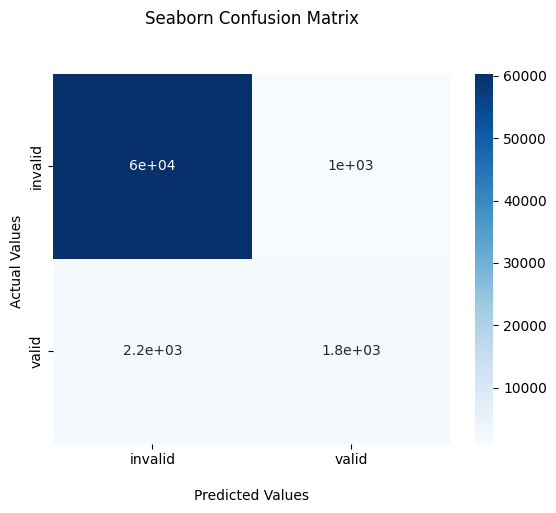

In [ ]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## VIẾT CODE cho task 13 ở đây:
    cf_matrix = CM(groundtruth, predictions)
    ax = sn.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

    plot.show()

class_names = ['invalid', 'valid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

**Task 14**: Tinh chỉnh mô hình - tinh chỉnh mô hình bằng cách sử dụng một số phương pháp sau:
* Tăng tối đa epoch, thay đổi batch size.
* Thay thế LSTM bằng các nút GRU và kiểm tra xem nó có thay đổi gì không.
* Thêm một layer LSTM/GRU khác hoặc thay thế nó bằng mô-đun Attention/Transformers, xem có cải thiện gì không.
* Thử với Dense layer (add/# units/...).
* Tìm các quy tắc tiền xử lý mà bạn có thể thêm để cải thiện chất lượng dữ liệu.
* Find another GloVe dictionary. Tìm một GloVe dictionary khác.
Yêu cầu: F1 score phải tăng thêm 2-3%.

In [ ]:
## VIẾT CODE cho task 14 ở đây:

In [ ]:
# Thay thế LSTM bằng GRU
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=max_features,
              output_dim=embed_size,
              input_length=max_len,
              embeddings_initializer=tensorflow.keras.initializers.Constant(embedding_matrix),
              trainable=False)(inputs)
x = Bidirectional(layers.GRU(50,
                             dropout=0.1,
                             recurrent_dropout=0.1,
                             return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation='sigmoid')(x)
model_1 = Model(inputs=inputs, outputs=outputs)

model_1.compile(loss = 'binary_crossentropy',
                optimizer = Optimizer.Adam(),
                metrics = ['accuracy', tfa.metrics.F1Score(average='weighted', num_classes=2)])

model_1_his = model_1.fit(X_tr, y_tr, batch_size=4096, epochs=20, validation_data=(X_va, y_va), callbacks=[callbacks_list])

Epoch 1/20
287/287 [==============================] - 118s 387ms/step - loss: 0.2284 - accuracy: 0.9333 - f1_score: 0.9064 - val_loss: 0.1908 - val_accuracy: 0.9377 - val_f1_score: 0.9076 - lr: 0.0010
Epoch 2/20
287/287 [==============================] - 113s 393ms/step - loss: 0.1790 - accuracy: 0.9397 - f1_score: 0.9155 - val_loss: 0.1666 - val_accuracy: 0.9414 - val_f1_score: 0.9260 - lr: 0.0010
Epoch 3/20
287/287 [==============================] - 112s 390ms/step - loss: 0.1669 - accuracy: 0.9420 - f1_score: 0.9251 - val_loss: 0.1623 - val_accuracy: 0.9421 - val_f1_score: 0.9303 - lr: 3.0000e-04
Epoch 4/20
287/287 [==============================] - 112s 390ms/step - loss: 0.1641 - accuracy: 0.9427 - f1_score: 0.9275 - val_loss: 0.1608 - val_accuracy: 0.9431 - val_f1_score: 0.9294 - lr: 9.0000e-05
Epoch 5/20
287/287 [==============================] - 120s 419ms/step - loss: 0.1635 - accuracy: 0.9429 - f1_score: 0.9280 - val_loss: 0.1605 - val_accuracy: 0.9432 - val_f1_score: 0.9296 

In [ ]:
test_predictions_1, test_groundtruths_1 = get_prediction_classes(model_1,  X_te, y_te)
print(precision_score(test_groundtruths_1, test_predictions_1))
print(recall_score(test_groundtruths_1, test_predictions_1))
print(f1_score(test_groundtruths_1, test_predictions_1))

2041/2041 [==============================] - 67s 32ms/step
0.6450320512820513
0.20246478873239437
0.30819295558958654


In [ ]:
# Thay layer Transformer

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tensorflow.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [16]:
num_heads = 2
ff_dim = 32
transformer_block = TransformerBlock(embed_size, num_heads, ff_dim)

In [17]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=max_features,
              output_dim=embed_size,
              input_length=max_len,
              embeddings_initializer=tensorflow.keras.initializers.Constant(embedding_matrix),
              trainable=False)(inputs)
x = transformer_block(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation='sigmoid')(x)
model_2 = Model(inputs=inputs, outputs=outputs)

model_2.compile(loss = 'binary_crossentropy',
                optimizer = Optimizer.Adam(learning_rate=1e-2),
                metrics = ['accuracy', tfa.metrics.F1Score(average='weighted', num_classes=2)])

model_2.fit(X_tr, y_tr, batch_size=4096, epochs=20, validation_data=(X_va, y_va), callbacks=[callbacks_list])

Epoch 1/20
287/287 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9373 - f1_score: 0.9078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 38s 94ms/step - loss: 0.2378 - accuracy: 0.9373 - f1_score: 0.9078 - val_loss: 0.2553 - val_accuracy: 0.9377 - val_f1_score: 0.9076 - lr: 0.0100
Epoch 2/20
287/287 [==============================] - 27s 93ms/step - loss: 0.1975 - accuracy: 0.9391 - f1_score: 0.9142 - val_loss: 0.1823 - val_accuracy: 0.9394 - val_f1_score: 0.9240 - lr: 0.0100
Epoch 3/20
287/287 [==============================] - 29s 101ms/step - loss: 0.1718 - accuracy: 0.9425 - f1_score: 0.9273 - val_loss: 0.1830 - val_accuracy: 0.9411 - val_f1_score: 0.9269 - lr: 0.0030
Epoch 4/20
287/287 [==============================] - 27s 94ms/step - loss: 0.1686 - accuracy: 0.9432 - f1_score: 0.9291 - val_loss: 0.1758 - val_accuracy: 0.9417 - val_f1_score: 0.9272 - lr: 9.0000e-04
Epoch 5/20
287/287 [==============================] - 23s 81ms/step - loss: 0.1675 - accuracy: 0.9435 - f1_score: 0.9297 - val_loss: 0.1738 - val_accuracy: 0.9417 - val_f1_score: 0.9272 - lr: 2.7000e-04
Epoch 6

In [20]:
test_predictions_2, test_groundtruths_2 = get_prediction_classes(model_2, X_te, y_te)
print(precision_score(test_groundtruths_2, test_predictions_2))
print(recall_score(test_groundtruths_2, test_predictions_2))
print(f1_score(test_groundtruths_2, test_predictions_2))

2041/2041 [==============================] - 7s 3ms/step
0.6376
0.20045271629778671
0.3050133945656333


In [ ]:
# Thêm một layer LSTM
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=max_features,
              output_dim=embed_size,
              input_length=max_len,
              embeddings_initializer=tensorflow.keras.initializers.Constant(embedding_matrix),
              trainable=False)(inputs)
x = Bidirectional(LSTM(50,
                           return_sequences=True,
                           dropout=0.1,
                           recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(50,
                           return_sequences=True,
                           dropout=0.1,
                           recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation='sigmoid')(x)
model_3 = Model(inputs=inputs, outputs=outputs)

model_3.compile(loss = 'binary_crossentropy',
                optimizer = Optimizer.Adam(learning_rate=1e-2),
                metrics = ['accuracy', tfa.metrics.F1Score(average='weighted', num_classes=2)])

model_3.fit(X_tr, y_tr, batch_size=4096, epochs=20, validation_data=(X_va, y_va), callbacks=[callbacks_list])

Epoch 1/20
287/287 [==============================] - 258s 855ms/step - loss: 0.1973 - accuracy: 0.9395 - f1_score: 0.9170 - val_loss: 0.1557 - val_accuracy: 0.9441 - val_f1_score: 0.9311 - lr: 0.0100
Epoch 2/20
287/287 [==============================] - 243s 848ms/step - loss: 0.1446 - accuracy: 0.9480 - f1_score: 0.9408 - val_loss: 0.1411 - val_accuracy: 0.9454 - val_f1_score: 0.9452 - lr: 0.0100
Epoch 3/20
287/287 [==============================] - 244s 852ms/step - loss: 0.1342 - accuracy: 0.9506 - f1_score: 0.9451 - val_loss: 0.1317 - val_accuracy: 0.9503 - val_f1_score: 0.9472 - lr: 0.0030
Epoch 4/20
287/287 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9515 - f1_score: 0.9463

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/287 [==============================] - 244s 850ms/step - loss: 0.1313 - accuracy: 0.9515 - f1_score: 0.9463 - val_loss: 0.1301 - val_accuracy: 0.9508 - val_f1_score: 0.9473 - lr: 9.0000e-04
Epoch 5/20
287/287 [==============================] - 243s 845ms/step - loss: 0.1301 - accuracy: 0.9519 - f1_score: 0.9469 - val_loss: 0.1300 - val_accuracy: 0.9503 - val_f1_score: 0.9479 - lr: 2.7000e-04
Epoch 6/20
287/287 [==============================] - 242s 844ms/step - loss: 0.1300 - accuracy: 0.9519 - f1_score: 0.9470 - val_loss: 0.1300 - val_accuracy: 0.9504 - val_f1_score: 0.9482 - lr: 8.1000e-05
Epoch 7/20
287/287 [==============================] - 245s 850ms/step - loss: 0.1299 - accuracy: 0.9518 - f1_score: 0.9469 - val_loss: 0.1300 - val_accuracy: 0.9504 - val_f1_score: 0.9481 - lr: 2.4300e-05
Epoch 8/20
287/287 [==============================] - 242s 844ms/step - loss: 0.1298 - accuracy: 0.9517 - f1_score: 0.9467 - val_loss: 0.1299 - val_accuracy: 0.9504 - val_f1_score: 0.9481 - l

In [ ]:
test_predictions_3, test_groundtruths_3 = get_prediction_classes(model_3, X_te, y_te)
print(precision_score(test_groundtruths_3, test_predictions_3))
print(recall_score(test_groundtruths_3, test_predictions_3))
print(f1_score(test_groundtruths_3, test_predictions_3))

2041/2041 [==============================] - 117s 57ms/step
0.6236093943139679
0.5075452716297787
0.5596228508042153
